In [494]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
import itertools
import nltk
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from autocorrect import Speller
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV,KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib
from sklearn.svm import SVC,LinearSVC
import xgboost as xgb
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from contractions import CONTRACTION_MAP
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [495]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\test.csv")

In [496]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it's hard not being able to see your mothers today but it's on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be there to bring you Mothers day flowers & a cwtch - honestly at this point I'd walk on hot coals to be able to. But I'll be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1


In [497]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [498]:
temp = train_data.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1701
0,-1,769
2,1,765


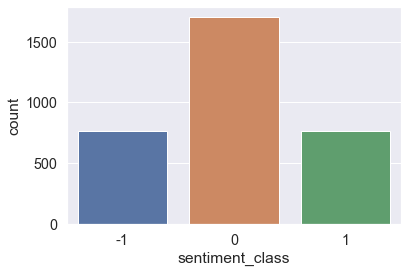

In [499]:
sns.countplot(x='sentiment_class',data=train_data)

In [500]:
train_data['retweet_count']=train_data['retweet_count'].astype(str)
test_data['retweet_count']=test_data['retweet_count'].astype(str)

In [501]:
train_data["retweet_count"]= train_data["retweet_count"].str.replace(r"[a-zA-Z$@#&*!''-/]",'')
train_data["retweet_count"]= train_data["retweet_count"].replace(r'^\s*$', np.nan, regex=True)

In [502]:
test_data["retweet_count"]= test_data["retweet_count"].str.replace(r"[a-zA-Z$@#&*!''-/]",'')
test_data["retweet_count"]= test_data["retweet_count"].replace(r'^\s*$', np.nan, regex=True)

In [503]:
train_data['retweet_count']=pd.to_numeric(train_data['retweet_count'])
test_data['retweet_count']=pd.to_numeric(test_data['retweet_count'])

In [504]:
train_data.loc[train_data["retweet_count"]<0,'retweet_count']=0
train_data.loc[train_data["retweet_count"].isna(),'retweet_count']=0
test_data.loc[test_data["retweet_count"]<0,'retweet_count']=0
test_data.loc[test_data["retweet_count"].isna(),'retweet_count']=0
train_data.loc[train_data["retweet_count"]>1000,'retweet_count']=1000
test_data.loc[test_data["retweet_count"]>1000,'retweet_count']=1000

In [505]:
train_data["retweet_count"]=train_data["retweet_count"].astype(int)
test_data["retweet_count"]=test_data["retweet_count"].astype(int)

In [506]:
train_data['lang'].value_counts()

en                            2994
 pink Peruvian opal! via      4   
 Find More                    2   
WORLDS OKAYEST MOTHER! &lt    2   
&gt                           2   
                             ..   
0.7231463898                  1   
0.1666662023                  1   
0.6236458018                  1   
 very much loved🥰️ …          1   
0.0903948317                  1   
Name: lang, Length: 232, dtype: int64

In [507]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [508]:
train_data['original_text']=train_data['original_text'].apply(expand_contractions)
test_data['original_text']=test_data['original_text'].apply(expand_contractions)

In [509]:
## Number of words in the original_text ##
train_data["num_words"] = train_data["original_text"].apply(lambda x: len(str(x).split()))
test_data["num_words"] = test_data["original_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the original_text ##
train_data["num_unique_words"] = train_data["original_text"].apply(lambda x: len(set(str(x).split())))
test_data["num_unique_words"] = test_data["original_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the original_text ##
train_data["num_chars"] = train_data["original_text"].apply(lambda x: len(str(x)))
test_data["num_chars"] = test_data["original_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the original_text ##
train_data["num_stopwords"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_data["num_stopwords"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the original_text ##
train_data["num_punctuations"] =train_data['original_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_data["num_punctuations"] =test_data['original_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the original_text ##
train_data["num_words_upper"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_data["num_words_upper"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the original_text ##
train_data["num_words_title"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_data["num_words_title"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the original_text ##
train_data["mean_word_len"] = train_data["original_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data["mean_word_len"] = test_data["original_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [510]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it is hard not being able to see your mothers today but it is on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0,45,37,254,27,7,1,2,4.666667
1,1.245759e+18,Happy Mothers Day Mum - I am sorry I cannot be there to bring you Mothers day flowers & a cwtch - honestly at this point I would walk on hot coals to be able to. But I will be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0,63,50,309,28,16,5,12,3.920635
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1,51,47,298,20,11,1,8,4.862745
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0,18,17,155,6,8,0,1,7.666667
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1,42,37,254,15,8,1,7,5.071429


In [511]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment_class')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment_class', size=5, hue='sentiment_class', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [512]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def split_words(self,input_text):
        return ''.join(re.findall('[A-Z][^A-Z]*', input_text))
    
    def standardize_words(self,input_text):
        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    '''def correct_spell(self,input_text):
        words = input_text.split() 
        clean_words = [str(TextBlob(word).correct()) for word in words] 
        return " ".join(clean_words)'''
    
    """def correct_spell(self,input_text):
        words = input_text.split() 
        spell = Speller(lang='en') 
        correct_words = [spell(word) for word in words] 
        return " ".join(correct_words) """
    '''def remove_meaningless(self,input_text):
        words = set(nltk.corpus.words.words())
        return " ".join(w for w in nltk.wordpunct_tokenize(input_text) if w.lower() in words or not w.isalpha())'''
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.split_words).apply(self.standardize_words).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [513]:
ct = CleanText()
train_data['original_text'] = ct.fit_transform(train_data.original_text)
test_data['original_text']=ct.fit_transform(test_data.original_text)

In [514]:
def clean_text(text_df):
    text_df["clean_text"]= text_df["original_text"].str.replace("mum", "mother", case = False)
    text_df["clean_text"]= text_df["clean_text"].str.replace("mom", "mother", case = False)
    text_df["clean_text"]= text_df["clean_text"].str.replace("mothersday","mother day") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("httpswww","") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("http","") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("u","") 
    return text_df

In [515]:
train_df=clean_text(train_data)
test_df=clean_text(test_data)

In [516]:
tokenizer = nltk.WordPunctTokenizer()
def pos_tagger(input_text):
    text = tokenizer.tokenize(input_text)
    tagged_text = nltk.pos_tag(text)
    new_text = ""
    for tag in tagged_text:
        new_text = new_text + " " + tag[1]
    return new_text

In [517]:
train_df['pos_text'] = train_df['clean_text'].apply(pos_tagger)
test_df['pos_text'] = test_df['clean_text'].apply(pos_tagger)

In [518]:
def stemming(input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
def lemmatize_text(input_text):
        word_list = nltk.word_tokenize(input_text)
        lemmatizer = WordNetLemmatizer() 
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

        return lemmatized_output

In [519]:
train_df['clean_text'] = train_df['clean_text'].apply(stemming)
test_df['clean_text'] = test_df['clean_text'].apply(stemming)

In [520]:
train_df['clean_text'] = train_df['clean_text'].apply(lemmatize_text)
test_df['clean_text'] = test_df['clean_text'].apply(lemmatize_text)

In [521]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [522]:
y = train_df.sentiment_class
X = train_df.drop(['id','original_text','sentiment_class','lang','original_author'],axis=1)

In [523]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [524]:
test_df_id=test_df.id
test_df.drop(['id','original_text','lang','original_author'],axis=1)

,retweet_count,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,clean_text,pos_text
0,0,56,46,275,24,10,7,10,3.928571,yeah cook potato year old mean threw bag spd toilet happi mother day made breakfast time thoght cool draw nake ladi dachshnd overhead projector psycholog class,NN VBD NNS NNS JJ JJ NN NN JJ NN JJ NNS NN VBD NN NN JJ NN VBG JJ NN NN JJ NN NN NN
1,0,22,22,192,6,13,0,3,7.772727,happi mother day mother step mother grandmoth dad cover parent role mother day motheringsnday s twitter com soapandglori tat,JJ NNS NN NNS VBP NNS NNS VBP JJ JJ NNS RB NN JJ JJ NN NN NN NNS
2,0,44,35,237,20,9,3,9,4.409091,love peopl k howev awok saw mother day trend woke american immedi happi mother day mother across way god bless love share sacrific make,NN NNS VBP RB RB VBD CC NN VBG VBD JJ RB JJ NNS NN NNS IN NN NN NN IN NN NNS VBP
3,1,30,28,203,9,10,1,5,5.800000,happi st birthday happi mother ’ day mother can ’ t see today keep safe shame mani other ignor advic covidー mother day motheringsnday pic twitter com vsvmkmfptr,JJ NN NN JJ NN JJ JJ NN NN MD VB JJ NN NN VB JJ NN JJ NNS VBG NN NN NN NN VBD JJ NN NN NN
4,0,39,34,200,20,2,0,3,4.153846,happi mother day wonderfl mother world live present alway reli mother rock famili whatev life throw,JJ NNS NN IN NNS NN VBP NN RB RB JJ NN NNS WDT NN NNS
...,...,...,...,...,...,...,...,...,...,...,...
1382,0,26,24,202,9,7,1,3,6.807692,happi mother ’ day crazi bitch i ’ m sorri covid bloodi rine love drag qeen lovehaterelationship iloveyomorethanninawest mother day pic twitter com koozccyf,JJ NN JJ JJ NN JJ NN NN VBP NN NN NN NN VBD JJR NN NNS JJ JJ NN NN VBP NN NN NN
1383,0,39,36,271,12,19,0,11,5.974359,mother can not get bingo broght bingo top prize incld terri chocol orang kinder happi hippo pack trkish delight mother fave happymoth day mother day instagram com ctnnm igshid kaehoi,NN NN VB JJ JJ NN NN NNS VBD JJ NN NN NN JJ NN NN JJ NNS NNS VBP DT NN RB NN JJ NN NN NN NN
1384,0,40,34,226,18,11,0,5,4.675000,despit bllshit today one favorit day lonng time danc dont took photo drive daphn chine qiz happi mother ’ day fckcovid mother day famili,IN VBN NN CD NN NNS VBP NN JJ NNS VBD NNS JJ NN JJ NN JJ NN JJ JJ NN VB RB NN NN
1385,0,32,27,270,10,20,1,9,7.468750,happi mother day firstli qeen danielesllivan loveyowithallmyheart also wish special ladi wonderfl mother day mother mothermi instagram com dqjnqhzlov tllkkowcjdbba vdan igshid qtlpjnf,JJ NNS NN RB JJ NN NN RB VBG JJ NNS VBP NNS NN NNS VBP JJ NN NN NN NNS VBP NN


In [525]:
train_df.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,clean_text,pos_text
0,1.245025e+18,happy mothersday amazing mothers know hard not able see mothers today us protect vulnerable members society beatcoronavirus pic twitter com vanfjfqb,en,0,BeenXXPired,0,45,37,254,27,7,1,2,4.666667,happi mother day amaz mother know hard not abl see mother today s protect vlnerabl member societi beatcoronavir pic twitter com vanfjfqb,JJ NN NN VBG NNS VBP RB RB JJ NN NNS NN VBP NN JJ NNS VBP NNS VBP NN NN NN
1,1.245759e+18,happy mothers day mum sorry cannot bring mothers day flowers cwtch honestly point would walk hot coals able bells soon love lots xx need photos https photos app goo gl mvxblrsczdte,en,1,FestiveFeeling,0,63,50,309,28,16,5,12,3.920635,happi mother day mother sorri can not bring mother day flower cwtch honestli point wold walk hot coal abl bell soon love lot xx need photo s photo app goo gl mvxblrsczdte,JJ NNS NN NN NN NN VBG NNS NN NNS VBP RB JJ JJ NN JJ NNS JJ NNS RB VBP NNS VBP VBP NNS VB NNS JJ JJ NN NN
2,1.246087e+18,happy mothers day mothers days work today quiet time reflect dog walk finish jigsaw garden learn guitar chords drunk strawberry gin tonic watch lee evens dvd favourite place visit isolate pic twitter com gzxvvff,en,0,KrisAllenSak,-1,51,47,298,20,11,1,8,4.862745,happi mother day mother day work today qiet time reflect dog walk finish jigsaw garden learn gitar chord drnk strawberri gin tonic watch lee even dvd favorit place visit isol pic twitter com gzxvvff,JJ NNS NN NNS NNS VBP NN JJ NN JJ NN VBP JJ NN NN NN NN NNS VBP JJ NN JJ NN NN VBZ JJ JJ NN NN NN NN NN NN NN
3,1.244803e+18,happy mothers day beautiful woman royalty soothes mummy jeremy emerald prayforroksie ultimateloveng pic twitter com oeetipvv,en,0,Queenuchee,0,18,17,155,6,8,0,1,7.666667,happi mother day beatifl woman royalti sooth mothermi jeremi emerald prayforroksi ltimateloveng pic twitter com oeetipvv,JJ NNS NN IN NN NN NNS VBP NN NN NN NN NN NN NN NN
4,1.244876e+18,remembering amazing ladies made late grandmother iris mum carol great grandmother ethel missed never forgotten happy mothers day great mums love sent xx pic twitter com xzzdeybje,en,0,brittan17446794,-1,42,37,254,15,8,1,7,5.071429,rememb amaz ladi made late grandmoth iri mother carol great grandmoth ethel miss never forgotten happi mother day great mother love sent xx pic twitter com xzzdeybj,VBG VBG NNS VBN JJ NN NN NN NN JJ NN NN VBD RB VBN JJ NNS NN JJ NNS VBP VBD NNP NN NN NN NN


In [526]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def gen_model_features(vect=None, is_w2v=None):
    
    textcountscols = ['num_words','num_unique_words','num_chars','num_stopwords'
                      ,'num_punctuations','num_words_upper','num_words_title','mean_word_len']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', vect)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', vect)]))]
                                , n_jobs=-1)
    return features

def grid_vect(clf, parameters_clf, X_train, X_test, features, parameters_text=None):
    pipeline = Pipeline([('features', features),('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search_model = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5,random_state=42)
    
    print("Performing grid search...")
    grid_search_model.fit(X_train, y_train)
    print("Best CV score: %0.3f" % grid_search_model.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search_model.best_estimator_.get_params()
    #final_model=grid_search_model.best_estimator_
    #final_model.fit(X,y)
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search_model.best_estimator_.score(X_test, y_test))
                 
    return grid_search_model.best_estimator_

In [527]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe1__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe1__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe1__vect__min_df': (1,2,3,4,5),
    'features__pipe2__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe2__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe2__vect__min_df': (1,2,3,4,5)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.01,0.1, 0.25, 0.5, 0.75),
    'clf__fit_prior' : (True,False)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__fit_intercept': (True,False),
    'clf__class_weight':['balanced',None]
}
parameters_sgd = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2','elasticnet'),
    'clf__max_iter': (10, 25, 50, 75, 100),
    'clf__class_weight':['balanced',None]
}
parameters_svc = {'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma':[0.1,1,10],
                    'clf__C':[0.1,1,0.001,0.0001],
                  'clf__class_weight':['balanced',None]
                 }
parameters_linsvc = {'clf__loss' : ['hinge', 'squared_hinge'],
                    'clf__penalty': ('l1', 'l2'),
                    'clf__class_weight':['balanced',None],
                    'clf__max_iter':[100,500],
                    'clf__C':[0.1,1,0.001,0.0001]
                     
                 }

parameters_gbm = {'clf__loss':['deviance','exponential'],
         'clf__learning_rate': [0.05,0.1],
         'clf__max_depth':[5,10,20],
         'clf__n_estimators': [10,25,50]
        }
parameters_xgb = {'clf__learning_rate':[0.01,0.1],
         'clf__n_estimators':[50,100,500],
         'clf__max_depth':[5,10,15,20],
        'clf__class_weight':['balanced',None],
         'clf__objective':'reg:linear'
        }

In [528]:
best_scores={}
best_models={}
mnb = MultinomialNB()
logreg = LogisticRegression()
sgd=SGDClassifier()
svc=SVC()
linsvc = LinearSVC()
gbm=GradientBoostingClassifier()
xgb_model=xgb.XGBClassifier()

In [529]:
countvect = CountVectorizer()
tfidfvect = TfidfTransformer()
# MultinomialNB
model_features=gen_model_features(countvect)
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_mnb=best_mnb_countvect.predict(X_test)
mnb_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
train_pred1=best_mnb_countvect.predict(X_train)
test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.4s finished


Best CV score: 0.410
Best parameters set:
	clf__alpha: 0.5
	clf__fit_prior: True
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 1
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.457

Accuracy score of Multinomial naive bayes algorithm -----> 40.64910127716197


In [342]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

(1387,)


In [530]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_logreg = best_logreg_countvect.predict(X_test)
logreg_score=100*(f1_score(y_test,prediction_logreg,average='weighted'))
#best_scores['logreg_countvect']=best_logreg_countvect.best_score_
#best_models['logreg_countvect']=best_logreg_countvect
train_pred2=best_logreg_countvect.predict(X_train)
test_pred2=best_logreg_countvect.predict(X_test)
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.7s finished


Best CV score: 0.409
Best parameters set:
	clf__C: 0.5
	clf__class_weight: None
	clf__fit_intercept: False
	clf__penalty: 'l2'
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 4
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 1.0
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.495

Accuracy score of Log Reg algorithm -----> 38.72164788020047


In [531]:
# SGD
best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_sgd = best_sgd_countvect.predict(X_test)
sgd_score=100*(f1_score(y_test,prediction_sgd,average='weighted'))
#best_scores['sgd_countvect']=best_sgd_countvect.best_score_
#best_models['sgd_countvect']=best_sgd_countvect
train_pred3=best_sgd_countvect.predict(X_train)
test_pred3=best_sgd_countvect.predict(X_test)
print("\nAccuracy score of SGD algorithm -----> " + str(sgd_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.2s finished


Best CV score: 0.327
Best parameters set:
	clf__alpha: 1e-06
	clf__class_weight: None
	clf__max_iter: 100
	clf__penalty: 'l1'
	features__pipe1__vect__max_df: 1.0
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 1)
	features__pipe2__vect__max_df: 1.0
	features__pipe2__vect__min_df: 4
	features__pipe2__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.522

Accuracy score of SGD algorithm -----> 35.99540091227806


In [532]:
# SVC
best_svc_countvect = grid_vect(svc, parameters_svc, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_svc = best_svc_countvect.predict(X_test)
svc_score=100*(f1_score(y_test,prediction_svc,average='weighted'))
#best_scores['svc_countvect']=best_svc_countvect.best_score_
#best_models['svc_countvect']=best_svc_countvect
train_pred4=best_svc_countvect.predict(X_train)
test_pred4=best_svc_countvect.predict(X_test)
print("\nAccuracy score of SVC algorithm -----> " + str(svc_score))


Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.0s finished


Best CV score: 0.364
Best parameters set:
	clf__C: 1
	clf__class_weight: 'balanced'
	clf__gamma: 1
	clf__kernel: 'rbf'
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 4
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 1.0
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.524

Accuracy score of SVC algorithm -----> 36.30244529886354


In [533]:
# GBC
best_gbm_countvect = grid_vect(gbm, parameters_gbm, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_gbm = best_gbm_countvect.predict(X_test)
gbm_score=100*(f1_score(y_test,prediction_gbm,average='weighted'))
#best_scores['gbm_countvect']=best_gbm_countvect.best_score_
#best_models['gbm_countvect']=best_gbm_countvect
train_pred5=best_gbm_countvect.predict(X_train)
test_pred5=best_gbm_countvect.predict(X_test)
print("\nAccuracy score of gbc algorithm -----> " + str(gbm_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.4s finished


Best CV score: 0.368
Best parameters set:
	clf__learning_rate: 0.05
	clf__loss: 'deviance'
	clf__max_depth: 10
	clf__n_estimators: 25
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 1
	features__pipe1__vect__ngram_range: (2, 2)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 4
	features__pipe2__vect__ngram_range: (2, 2)
Test score with best_estimator_: 0.519

Accuracy score of gbc algorithm -----> 36.719117162714916


In [139]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_gbm_countvect.fit(X,y)
gbm_predictions=best_gbm_countvect.predict(test_df)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=gbm_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [153]:
# GBC
best_linsvc_countvect = grid_vect(linsvc, parameters_linsvc, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_linsvc = best_linsvc_countvect.predict(X_test)
linsvc_score=100*(f1_score(y_test,prediction_linsvc,average='weighted'))
#best_scores['gbm_countvect']=best_gbm_countvect.best_score_
#best_models['gbm_countvect']=best_gbm_countvect
train_pred5=best_gbm_countvect.predict(X_train)
test_pred5=best_gbm_countvect.predict(X_test)
print("\nAccuracy score of gbc algorithm -----> " + str(linsvc_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


Best CV score: 0.364
Best parameters set:
	clf__C: 0.0001
	clf__class_weight: 'balanced'
	clf__loss: 'hinge'
	clf__max_iter: 500
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 4
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.513

Accuracy score of gbc algorithm -----> 35.93260213797531


In [155]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_linsvc_countvect.fit(X,y)
linsvc_predictions=best_linsvc_countvect.predict(test_df)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=linsvc_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [31]:
from sklearn.ensemble import VotingClassifier
countvect_classifier= VotingClassifier(estimators=[('mnb', best_models['mnb_countvect']), ('lr', best_models['logreg_countvect']),
                         ('sgd', best_models['sgd_countvect']), ('svc', best_models['svc_countvect']),
                         ('gbm', best_models['gbm_countvect'])],voting='hard')
countvect_classifier.fit(X_train,y_train)
countvect_classifier_predictions=countvect_classifier.predict(X_test)
countvect_classifier_predictions_score=100*(f1_score(y_test,countvect_classifier_predictions,average='weighted'))
print("\nAccuracy score of Voting Classifier algorithm -----> " + str(countvect_classifier_predictions_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.3s finished



Accuracy score of Voting Classifier algorithm -----> 38.736922949489525


In [32]:
df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),
                      pd.DataFrame(train_pred3),pd.DataFrame(train_pred4),pd.DataFrame(train_pred5)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)
                     ,pd.DataFrame(test_pred4),pd.DataFrame(test_pred5)], axis=1)


In [33]:
df_train.columns=['mnb','lr','sgd','svc','gbm']
df_test.columns=['mnb','lr','sgd','svc','gbm']

In [34]:
df_train.shape

(2588, 5)

In [35]:
from xgboost import XGBClassifier

def hyperparameter_tuner(model,X_train,y_train,hp_list):
    
    hp_perf=[]
    hp_model=RandomizedSearchCV(model,param_distributions=hp_list,n_iter=10,n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5)
    hp_model.fit(X_train,y_train)
    best_hp_model=hp_model.best_estimator_
    best_param=hp_model.best_params_
    best_score=hp_model.best_score_  
   
    return best_hp_model,best_param,best_score

xgb=XGBClassifier({
    'objective': 'multi:softprob',
    'eta': 0.1,
    'max_depth': 3,
    'silent' :1,
    'num_class' : 3,
    'eval_metric' : "mlogloss",
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'seed':17,
    'num_rounds':2000,
})
xgb.fit(df_train,y_train)

#best_model,best_params,best_score=hyperparameter_tuner(xgb,df_train,y_train,parameters_xgb)

prediction_xgb = xgb.predict(df_test)
xgb_score=100*(f1_score(y_test,prediction_xgb,average='weighted'))
print("\nAccuracy score of XGB stacking algorithm -----> " + str(xgb_score))


Accuracy score of XGB stacking algorithm -----> 40.41467204614164


In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
model = BaggingClassifier(RandomForestClassifier(max_depth=25,min_samples_leaf=2,n_estimators=25))
model.fit(df_train,y_train)
bagging_pred = model.predict(df_test)
bagging_score=100*(f1_score(y_test,bagging_pred,average='weighted'))
print("\nAccuracy score of Random Forest Bagging algorithm -----> " + str(bagging_score))


Accuracy score of Random Forest Bagging algorithm -----> 40.13882393849355
